
<img src="https://i.imgur.com/12tfKrD.png" alt="Alin">
</img>


# Demo RNN -- 張愛玲散文集AI二次創作

資料集: 張愛玲繁體中文小說 《傳奇》

爬蟲來源: [crawl_book](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)

程式碼參考: [Tensorflow](https://www.tensorflow.org/tutorials/text/text_generation)

本次資料集，著作權乃是張愛玲女士所擁有。**請勿將本次資料集散播、更改、用於非商業用途**。

> **資料集說明**

今年是張愛玲女士101年誕辰。張愛玲出生名門，曾就讀於香港大學和聖約翰大學，受過良好的中西教育。上海淪陷時期，陸續發表《沉香屑·第一爐香》、《傾城之戀》、《心經》、《金鎖記》等中、短篇小說，震動上海文壇。

這次訓練取張愛玲散文集《傳奇》作為訓練，《傳奇》收留五篇散文: 「留情」、「鴻鸞禧」、「紅玫瑰與白玫瑰」、「等」、「桂花蒸阿小悲秋」。其中以「紅玫瑰與白玫瑰」最為膾炙人口。

> **訓練步驟**

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集 
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型
7. 做預測

> **本次模型介紹 RNN**

![](https://i.imgur.com/FaY50C8.png)


我們來看看維度，很多人會搞不懂RNN的維度:

一個Seq通過RNN後的維度

* Input: (Seq,${originDim}$)
* RNN Neuron: 2048
* Output: (Seq,2048) if (return_sequence == True) else (1,2048)
![](https://i.imgur.com/9SVl6JR.png)

![](https://i.imgur.com/z4ElFIr.png)

**把生成問題變成分類問題**

![](https://i.imgur.com/TBHKuf6.png)


In [1]:
# 開始執行前請先在心中默念著作權相關法律，並發誓只將資料集用於教學用途
# 請下載失去著作權保護期的書籍 (50年)
# 執行即代表已完成閱讀著作權辦法，並同意遵循著作權相關條例

import requests
from lxml import etree
import re 
import urllib
from tqdm import tqdm
import os

if(os.path.isdir("./books") == False):
  os.mkdir("./books")


In [2]:
def get_book_information(url):
  url_chinese = urllib.parse.unquote(url)
  url_re = re.compile(r'com/(.*)\.php')
  url_re2 = re.compile(r'.*\.php')
  url_re3 = re.compile(r'\.(html|xhtml)')
  save_path = "./books/"+url_re.search(url_chinese).group(1).strip()+".txt"
  url_book_domain = url_re2.match(url).group(0)
  html_format = url_re3.search(url).group(0)
  print("儲存位置: "+save_path)
  return save_path,url_book_domain,html_format


In [3]:
def get_pages_of_book(url):
  response = requests.get(url+"#book_toc")
  html = etree.HTML(response.content)
  content_number = len(html.xpath('.//div[@data-role="content"]//ul/li'))
  return content_number


In [4]:
def download_one_book(url):
  save_path,url_book_domain,html_format = get_book_information(url)
  content_number = get_pages_of_book(url)
  page_start = 2 if(html_format == ".html") else 1
  page_end = page_start+content_number
  file = open(save_path,"w",encoding="utf8")
  for page in tqdm(range(page_start,page_end)):
      if(html_format == ".html"):
          url_ = url_book_domain+"/"+(str(page) if page>9 else "0"+str(page))+html_format
      else:
          url_ = url_book_domain+"/"+str(page)+html_format
      response = requests.get(url_)
      html = etree.HTML(response.content.decode("utf-8","replace"))
      if(html_format == ".html"):
          content = html.xpath('.//div[@data-role="content"]/p/text()')
      else:
          content = html.xpath('.//div[@data-role="content"]/div/text()')
      assey = [a.strip().replace("\u3000"," ") for a in content]
      file.write("\n".join(assey)+"\n")
  file.flush()
  file.close()

url = "https://www.bookscool.com/%E5%8D%A1%E7%B9%86-%E7%95%B0%E9%84%89%E4%BA%BA.php/0.xhtml"
download_one_book(url)


# ****************************************
# **請勿將本次資料集散播、用於非商業用途**
# ****************************************

# 執行即代表同意將會合法、合理使用資料集

#!wget -O Eileen_Legendary.txt "http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt"

儲存位置: ./books/卡繆-異鄉人.txt


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


## 1. 讀入Package

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## 2. 取得資料集

In [6]:
# 作業之一就是試試看其他本小說

book = ""
with open("/content/books/卡繆-異鄉人.txt","r",encoding="utf8") as file:
  for line in file:
    book += line

book_length = len(book)
unique_words = set(book)
print(f"共有 {book_length} 字詞")
print(f"包含了 {len(unique_words)} 個獨一無二的字 (含標點符號)\n")
print(book[0:500])

共有 55660 字詞
包含了 2127 個獨一無二的字 (含標點符號)


《二○一五年三月六日版》
《好讀書櫃》典藏版
第一部
１
今天，媽媽死了。也許是昨天，我不知道。我收到養老院的一封電報，說：「母死。明日葬。專此通知。」這說明不了什麼。可能是昨天死的。
養老院在馬朗戈，離阿爾及爾八十公里。我乘兩點鐘的公共汽車，下午到，還趕得上守靈，明天晚上就能回來。我向老闆請了兩天假，有這樣的理由，他不能拒絕。不過，他似乎不大高興。我甚至跟他說：「這可不是我的錯兒。」他沒有理我。我想我不該跟他說這句話。反正，我沒有什麼可請求原諒的，倒是他應該向我表示哀悼。不過，後天他看見我戴孝的時候，一定會安慰我的。現在有點像是媽媽還沒有死似的，不過一下葬，那可就是一樁已經了結的事了，一切又該公事公辦了。
我乘的是兩點鐘的汽車。天氣很熱。跟平時一樣，我還是在賽萊斯特的飯館裡吃的飯。他們都為我難受，賽萊斯特還說：「人只有一個母親啊。」我走的時候，他們一直送我到門口。我有點兒煩，因為我還得到艾瑪努埃爾那裡去借黑領帶和黑紗。他幾個月前剛死了叔叔。
為了及時上路，我是跑著去的。這番急，這番跑，加上汽車顛簸，汽油味兒，還有道路和天空亮得晃眼，把我弄得昏昏沉沉的。我幾乎睡了一路。我醒來的時候，


## 3. 資料前處理

文字前處理有一堆方法、作法:
* 切字
* 還原
* 清除特殊字符
* 清除不常見字符 (StopWord)


我這裡僅使用去除不常見的字(StopWord)

In [7]:
# 計算字數統計
words_count = {}
for w in book:
  if w in words_count:
    words_count[w] += 1
  else:
    words_count[w] = 1

words_count = sorted(words_count.items(),key=lambda x:x[1])

In [8]:
stop_word = 1
unique_words = [w_tup[0] for w_tup in words_count if w_tup[1]>stop_word]
print(f"去除次數小於{stop_word}的文字剩餘 : {len(unique_words)}")

去除次數小於1的文字剩餘 : 1650


In [9]:
print(f"原本的書共有 {book_length} 字詞")
print(f"去除不常出現的文字後")
book = [w for w in book if w in unique_words]
print(f"剩餘{len(book)}個字")

原本的書共有 55660 字詞
去除不常出現的文字後
剩餘55183個字


In [10]:
# 文字轉數字(index)
word_2_index = {word:index for index,word in enumerate(unique_words)}
index_2_word = {word_2_index[word]:word for word in word_2_index}

book_2_index = [word_2_index[w] for w in book]

print("原始文字 : ")
print(book[:40])
print("-"*40)
print("轉成index : ")
print({word_2_index[w] for w in book[:40]})

原始文字 : 
['\n', '《', '二', '○', '一', '五', '年', '三', '月', '六', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '典', '藏', '版', '\n', '第', '一', '部', '\n', '１', '\n', '今', '天', '，', '媽', '媽', '死', '了', '。', '也', '許']
----------------------------------------
轉成index : 
{0, 1, 1297, 1046, 1176, 1561, 1439, 1444, 1576, 297, 298, 299, 1202, 1606, 1611, 1357, 462, 1618, 1366, 1367, 1368, 1113, 1245, 1643, 1644, 1648, 1649, 1140, 1141, 1524, 1017}


In [11]:
def ind2word_seq(seq):
  return [index_2_word[i] for i in seq]

In [12]:
# 設定輸入模型長度
seq_len = 20
characters = tf.data.Dataset.from_tensor_slices(book_2_index)
# characters = characters.map(lambda w:word_2_index[w.item()])

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
  print(seq.shape)
  print(seq)
  print([index_2_word[i] for i in seq.numpy()])

(21,)
tf.Tensor(
[1618 1366 1357  297 1644 1046 1444 1367 1140 1113 1176  298 1368 1618
 1366 1576 1202 1017  462 1368    0], shape=(21,), dtype=int32)
['\n', '《', '二', '○', '一', '五', '年', '三', '月', '六', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '典']
(21,)
tf.Tensor(
[ 299  298 1618 1439 1644 1245 1618    1 1618 1141 1606 1649 1561 1561
 1524 1643 1648 1611 1297 1642  893], shape=(21,), dtype=int32)
['藏', '版', '\n', '第', '一', '部', '\n', '１', '\n', '今', '天', '，', '媽', '媽', '死', '了', '。', '也', '許', '是', '昨']


![](https://i.imgur.com/YMVMFEJ.png)


In [13]:
# 做input、target切割
def split_input_target(seq):
  input_txt = seq[:-1]
  target_txt = seq[1:]
  return input_txt,target_txt

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

![](https://i.imgur.com/YoHWLkf.png)


In [14]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
  print("Input :", ind2word_seq(input_example.numpy()))
  print("Target:", ind2word_seq(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())



Input : ['\n', '《', '二', '○', '一', '五', '年', '三', '月', '六', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》']
Target: ['《', '二', '○', '一', '五', '年', '三', '月', '六', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '典']
--------------------------------------------------
Input : [1618 1366 1357  297 1644 1046 1444 1367 1140 1113 1176  298 1368 1618
 1366 1576 1202 1017  462 1368]
Target: [1366 1357  297 1644 1046 1444 1367 1140 1113 1176  298 1368 1618 1366
 1576 1202 1017  462 1368    0]


In [15]:
# 建立資料集
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset shapes: ((64, 20), (64, 20)), types: (tf.int32, tf.int32)>

## 4. 建立模型

![](https://i.imgur.com/TBHKuf6.png)

In [16]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(unique_words), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=4096, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=2048, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(unique_words),activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         844800    
_________________________________________________________________
lstm (LSTM)                  (None, None, 4096)        75513856  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 2048)        50339840  
_________________________________________________________________
dense (Dense)                (None, None, 1650)        3380850   
Total params: 130,079,346
Trainable params: 130,079,346
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
  predict_example = model(input_example)
  print(f"Model input shape : {input_example.shape}")
  print(f"Model output shape : {predict_example.shape}")
  print(f"Model target shape : {target_exaple.shape}")

Model input shape : (64, 20)
Model output shape : (64, 20, 1650)
Model target shape : (64, 20)


In [18]:
print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index_2_word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
我。如果另一個上了，或是他掏出了刀子，我
----------------------------------------
輸入尚未訓練的model後獲得：

拾ＰＰＰＰ薄咂咂咂咂咂話話勾勾勾勾民民美


## 5. 制定訓練計畫並訓練

* [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) V.S. [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)

```python=
# categorical_crossentropy
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

# sparse_categorical_crossentropy
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

```


In [19]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [20]:
EPOCHS = 20
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
    
)

Epoch 1/20
41/41 [==============================] - 16s 343ms/step - loss: 6.8743
Epoch 2/20
41/41 [==============================] - 15s 354ms/step - loss: 5.9218
Epoch 3/20
41/41 [==============================] - 15s 367ms/step - loss: 5.8434
Epoch 4/20
41/41 [==============================] - 15s 372ms/step - loss: 5.7997
Epoch 5/20
41/41 [==============================] - 15s 363ms/step - loss: 5.6133
Epoch 6/20
41/41 [==============================] - 15s 356ms/step - loss: 5.3748
Epoch 7/20
41/41 [==============================] - 15s 355ms/step - loss: 5.1604
Epoch 8/20
41/41 [==============================] - 15s 360ms/step - loss: 4.9957
Epoch 9/20
41/41 [==============================] - 15s 365ms/step - loss: 4.7949
Epoch 10/20
41/41 [==============================] - 15s 364ms/step - loss: 4.6085
Epoch 11/20
41/41 [==============================] - 15s 362ms/step - loss: 4.4221
Epoch 12/20
41/41 [==============================] - 15s 360ms/step - loss: 4.2453
Epoch 13/20
4

## 6. 衡量模型

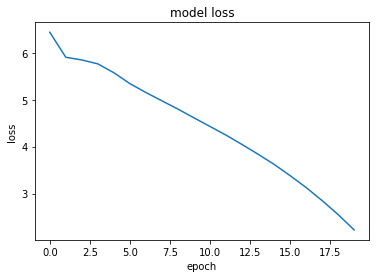

In [21]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [22]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index_2_word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
我。如果另一個上了，或是他掏出了刀子，我
----------------------------------------
輸入進訓練後的model後獲得：

的」果另一個人一，我是我的出了一子，我就


## 7. 做預測

![](https://i.imgur.com/YsOj6Mw.png)

在實際生成文字時，我們會想要增加一些隨機性。比如”天天出去” 不加入隨機 “天天天天” 如果我們全部輸出的字都是取softmax最大可能性，則一個訓練完美的model會把整本書給輸出出來。但是我們要的是，希望電腦在最大可能性的幾個字中隨機挑選一個字出來。

tf.random.categorical 會根據softmax機率後隨機挑選字，但是我們不希望因為模型很爛導致不合理的字被選中，因此我們會除上一個temperature來增加可能字的比重。

EX: "天天出去" 預測下一個字
1. 玩 : 0.3 
2. 天 : 0.1 
3. 浪 : 0.4 

"天"有的機率被印出，我們不希望。所以我們可以在每一個機率除上一個temperature(0.01)
1. 玩 : 30 
2. 天 : 10 
3. 浪 : 40 
原本"浪"跟"天"差0.3，除temperature後差30



In [23]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
  [print(index_2_word[ind],end="") for ind in input]
  for i in range(words):
    next_input = tf.expand_dims(input,axis=0)
    predicts = model(next_input)
    predicts = predicts[:,-1,:]
    predicts /= temperature
    result = tf.random.categorical(
        predicts,num_samples=1
    )
    chinese_ind = tf.squeeze(result).numpy()
    print(index_2_word[chinese_ind],end="")
    input = input+[chinese_ind]
    input = input[-seq_len:]

    

In [24]:
init_seq = "我們"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,500)

我們的淒然，我們的愕然，不是一個通言。他只以說，這是我的誇情，我在我的誤子基會的時刻，我房上了門房的聲音，我都看到了那一堆的岩石，我不知道這一點的可笑。他只是梧恕的理由，我只是說，這是我的最情，我竟不能出到我的忽要是這樣的生活。」我說：「您知道，我們的心音很多。我說：「您知道，我們的朋友。」我說：「是什麼？」我回答說我的意思。我問我是不是認為我的案子。」我說：「您知道，我們的朋友。」我說：「我們的朋友。」我回答說我對此了個什麼，他說我糊婚的是，他還是養老院的人。他說：「您知道，我們的律師對我的律師討論控告一個辦事處，我的心音是不發抖的。我的律師對我說：「您知道，我們的律師對我的律師討論控告一個辦事處，我的心音是不發抖的。我的律師對我說：「您知道，我們的律師對我的僻兒漢。他們問我是否是這樣的話，我就不說話了。我想知道我是否塵且的關係。我想知道我是否揍了。他想知道我是否有一個生活。」我問我是不是認為我的案子。他鮮磨的時候，我想知道我是否是穿得酸。我跟他說他不喜歡警察。我說：「您知道，我們的朋友。」檢察官問他是否是不是我的朋友。」檢察官問他是否允是我的里魂。我遍得很快。」他的聲音伙，我感到有點兒

In [25]:
# 不要執行這一個block
import time
while True:
  time.sleep(5)
  pass

KeyboardInterrupt: ignored

## 作業2.1 (30%)

使用[爬蟲程式](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)來取得一個新的文本資料集，或是不管你從哪裡取得的資料集也可以(不要再張愛玲了，不限中英文)。然後丟入這個模型來看看AI生成文字的成果，將**結果**與**你的心得**(不是機器產生的心得)，貼上pdf。

請隨意修改本colab的模型與參數來達到更好的結果。

資料集越有趣越好，比如你可以去爬PTT文章來製作廢文產生器。去爬Dcard製作幻想文產生器。

In [ ]:
result = generateWords(input,500)
print(result)
